## Model training

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from joblib import dump
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv('../data/processed/3_data_cleaning.csv', sep=';')
df.head(3)

,STATUS,ORBITAL_PERIOD_DAYS,TRANSIT_DURATION_HOURS,TRANSIT_DEPTH_PPM,PLANET_RADIUS_REARTH,PLANET_INSOLATION_EFLUX,PLANET_EQ_TEMP_K,STELLAR_TEFF_K,STELLAR_LOGG_CMS2,STELLAR_RADIUS_RSUN
0,1,9.49,2.96,615.8,2.26,93.59,793.0,5455.0,4.47,0.93
1,1,54.42,4.51,874.8,2.83,9.11,443.0,5455.0,4.47,0.93
2,1,19.90,1.78,10829.0,14.60,39.30,638.0,5853.0,4.54,0.87


## Split Data

### Normal

In [3]:
normal_feature = df.drop(['STATUS'], axis=1)
normal_target = df['STATUS']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(normal_feature, normal_target, train_size=0.8, random_state=42)

## Train

In [5]:
xgb = XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=500,
    random_state=42,
    objective='binary:logistic',
)

In [6]:
xgb.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [7]:
xgb_predict = xgb.predict(X_test)

In [8]:
accuracy = accuracy_score(y_test, xgb_predict)
print(f'Accuracy: {(accuracy * 100):.2f} %')

Accuracy: 84.35 %


In [9]:
matrix = confusion_matrix(y_test, xgb_predict)
matrix

array([[ 415,  333],
       [ 111, 1978]])

In [10]:
print(classification_report(y_test, xgb_predict))


              precision    recall  f1-score   support

           0       0.79      0.55      0.65       748
           1       0.86      0.95      0.90      2089

    accuracy                           0.84      2837
   macro avg       0.82      0.75      0.78      2837
weighted avg       0.84      0.84      0.83      2837



In [11]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
result = cross_val_score(xgb, normal_feature, normal_target, cv=kfold)
print(f'Accuracy: {(result.mean() * 100):.2f} %')

Accuracy: 82.69 %


In [13]:
importances = xgb.feature_importances_
features = X_train.columns

df_importance = pd.DataFrame({'feature': features, 'importance': importances})
df_importance = df_importance.sort_values('importance', ascending=False)
print(df_importance)

                   feature  importance
0      ORBITAL_PERIOD_DAYS    0.196556
1   TRANSIT_DURATION_HOURS    0.163983
2        TRANSIT_DEPTH_PPM    0.140335
3     PLANET_RADIUS_REARTH    0.139770
4  PLANET_INSOLATION_EFLUX    0.112399
8      STELLAR_RADIUS_RSUN    0.074607
6           STELLAR_TEFF_K    0.062183
7        STELLAR_LOGG_CMS2    0.056021
5         PLANET_EQ_TEMP_K    0.054147


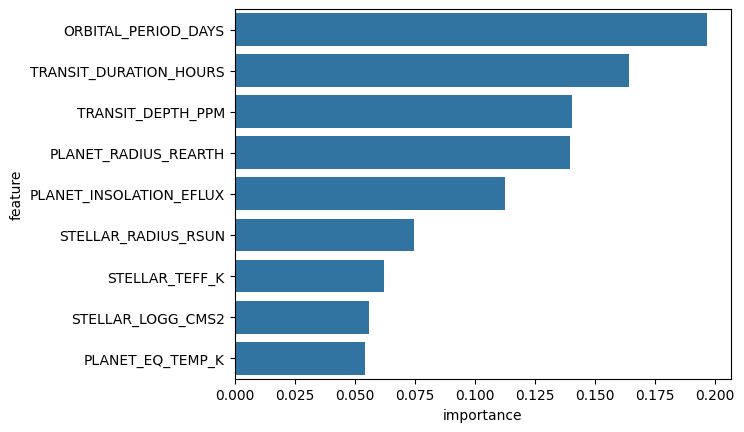

In [14]:
plt.figure()
sns.barplot(x=df_importance['importance'], y=df_importance['feature'])
plt.show()

In [15]:
xgb_proba = xgb.predict_proba(X_test)
xgb_proba = xgb_proba[:, 1]

In [16]:
confiability = xgb_proba.mean()
confiability

np.float32(0.736288)

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, xgb_proba)

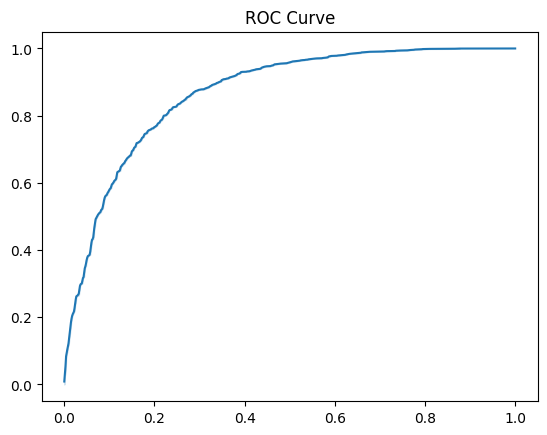

In [18]:
plt.figure()
plt.title('ROC Curve')
sns.lineplot(x=fpr, y=tpr)
plt.show()

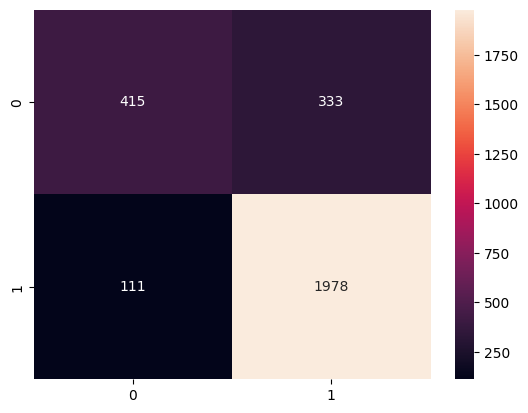

In [19]:
plt.figure()
sns.heatmap(matrix, annot=True, fmt='d')
plt.show()

In [20]:
xgb_final = XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=500,
    random_state=42,
    objective='binary:logistic'
)

In [21]:
xgb_final.fit(normal_feature, normal_target)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
xgb_final.predict([[9.49,2.96,615.8,2.26,93.59,793.0,5455.0,4.47,0.93]])

array([1])

In [23]:
dump(xgb_final, '../models/xgb_model.joblib')

['../models/xgb_model.joblib']